# MFA Validation Phoneme Analysis

## Comparative Analysis: Phoneme Recognition Accuracy Before and After Second Validation Step

This notebook performs a comparative analysis of phoneme recognition accuracy:
- **Before**: Baseline recognition using wav2vec2 + Needleman-Wunsch alignment
- **After**: Same baseline + Second Validation Step using trained models from german-phoneme-validator

### Key Features
1. **MFA Alignment**: Uses Montreal Forced Aligner for precise phoneme timing
2. **Second Validation Step**: Validates mismatches using trained acoustic models
3. **Comparative Metrics**: PER, Accuracy improvements after validation

### Dataset
- **Source**: TV-2021.02-Neutral (hochdeutsch pronunciation)
- **Sample size**: 1000 recordings (900 random + 100 with loanwords)

## 0. Configuration

**IMPORTANT:** Change `ANALYSIS_STAGE` before each run to get a new random sample and save results separately.

In [1]:
# =============================================================================
# ⚙️ ANALYSIS CONFIGURATION
# =============================================================================
# Change this value before each run to get a new random sample and separate reports
# Examples: 1, 2, 3, 4, etc.

ANALYSIS_STAGE = 1  # 👈 CHANGE THIS BEFORE EACH RUN!

# =============================================================================
# Derived parameters (DO NOT EDIT)
RANDOM_SEED = ANALYSIS_STAGE * 100  # Different seed for each stage
STAGE_SUFFIX = f"_stage{ANALYSIS_STAGE}"  # Suffix for report filenames

# MFA configuration
MFA_BIN = "/Volumes/SSanDisk/SpeechRec-German/miniforge/envs/mfa310/bin/mfa"
MFA_DICT = "german_mfa"
MFA_MODEL = "german_mfa"

# Validation configuration
VALIDATION_CONFIDENCE_THRESHOLD = 0.5
# Note: artifacts_dir is auto-detected from installed german-phoneme-validator package

print(f"{'='*80}")
print(f"🔬 ANALYSIS CONFIGURATION")
print(f"{'='*80}")
print(f"  Stage: {ANALYSIS_STAGE}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Report suffix: {STAGE_SUFFIX}")
print(f"  Reports will be saved as: phoneme_analysis_*{STAGE_SUFFIX}.csv")
print(f"  Validation confidence threshold: {VALIDATION_CONFIDENCE_THRESHOLD}")
print(f"{'='*80}")
print()
print(f"💡 TIP: To run a new analysis with different 1000 sentences:")
print(f"     1. Change ANALYSIS_STAGE to {ANALYSIS_STAGE + 1}")
print(f"     2. Run 'Restart & Run All'")
print(f"{'='*80}")

🔬 ANALYSIS CONFIGURATION
  Stage: 1
  Random seed: 100
  Report suffix: _stage1
  Reports will be saved as: phoneme_analysis_*_stage1.csv
  Validation confidence threshold: 0.5

💡 TIP: To run a new analysis with different 1000 sentences:
     1. Change ANALYSIS_STAGE to 2
     2. Run 'Restart & Run All'


## 1. Setup and Imports

In [2]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project paths
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))



# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import json
import re
import librosa
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# Project modules
from modules.phoneme_recognition import PhonemeRecognizer
from modules.g2p_module import get_expected_phonemes
from modules.phoneme_normalizer import get_phoneme_normalizer
from modules.alignment import needleman_wunsch_align
from modules.mfa_alignment import get_mfa_aligner, MFAConfig
from modules.metrics import calculate_per
from modules.forced_alignment import PhonemeSegment

# Validator module - import from library
# Since validator_project is already in sys.path, we can import directly
# The library provides validate_phoneme function and PhonemeValidator class
from german_phoneme_validator import validate_phoneme, PhonemeValidator, get_validator

print("✓ Successfully imported validate_phoneme and PhonemeValidator from german-phoneme-validator library")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print(f"Notebook directory: {notebook_dir}")
print(f"Validator project: {validator_project}")

CTC Forced Aligner loaded successfully
✓ Successfully imported validate_phoneme and PhonemeValidator from german-phoneme-validator library
Project root: /Volumes/SSanDisk/SpeechRec-German-diagnostic
Notebook directory: /Volumes/SSanDisk/SpeechRec-German-diagnostic/notebooks



## 2. Load Metadata and Sample Selection

In [3]:
# Load metadata CSV
metadata_path = project_root / 'data' / 'dictionaries' / 'metadata_wav_clean_hochdeutsch.csv'
df_full = pd.read_csv(metadata_path)

print(f"Total records: {len(df_full)}")
print(f"Columns: {df_full.columns.tolist()}")

# Fix audio paths
def fix_audio_path(old_path):
    """Convert CSV path to actual audio path."""
    if pd.isna(old_path):
        return None
    # Replace SpeechRec-German with audio_data
    new_path = old_path.replace('/SpeechRec-German/', '/audio_data/')
    return new_path

df_full['audio_path_fixed'] = df_full['audio_wav_path'].apply(fix_audio_path)

# Filter for TV-2021.02-Neutral subset only
df_subset = df_full[df_full['subset'] == 'TV-2021.02-Neutral'].copy()
print(f"\nTV-2021.02-Neutral subset: {len(df_subset)} records")

Total records: 37142
Columns: ['idx', 'id', 'subset', 'style', 'text', 'samplerate', 'durationSeconds', 'recording_year_month', 'microphone', 'language', 'comment', 'audio_wav_path', 'text_norm', 'phonemes_ipa']

TV-2021.02-Neutral subset: 22671 records


In [4]:
# Loanword patterns (case-insensitive)
LOANWORD_PATTERNS = [
    # English loanwords
    r'\bJob\b', r'\bJobs\b', r'\bComputer\b', r'\bManager\b', r'\bTeam\b',
    r'\bStart\b', r'\bInterview\b', r'\bService\b', r'\bBusiness\b',
    r'\bMarketing\b', r'\bCool\b', r'\bOkay\b', r'\bBaby\b', r'\bParty\b',
    r'\bEmail\b', r'\bOnline\b', r'\bInternet\b', r'\bSoftware\b',
    r'\bManagement\b', r'\bWorkshop\b', r'\bMeeting\b', r'\bUpdate\b',
    r'\bDownload\b', r'\bUpload\b', r'\bSmartphone\b', r'\bDesign\b',
    r'\bTrend\b', r'\bBrand\b', r'\bStyle\b', r'\bFashion\b',
    
    # French loanwords
    r'\bRestaurant\b', r'\bChic\b', r'\bPortemonnaie\b', r'\bRendezvous\b',
    r'\bCafé\b', r'\bBoutique\b', r'\bCousin\b', r'\bCousine\b',
    r'\bChance\b', r'\bChampagne\b', r'\bCharlotte\b',
    
    # Latin/Scientific
    r'\bInterstellar\b', r'\bInterstellare\b', r'\bUniversum\b',
    r'\bGalaxie\b', r'\bGalaxien\b', r'\bProjekt\b',
    
    # Italian loanwords
    r'\bPizza\b', r'\bPasta\b', r'\bEspresso\b', r'\bCappuccino\b',
    r'\bCiao\b', r'\bBravo\b',
    
    # Other common patterns
    r'\b\w*ing\b',  # Words ending in -ing (English gerunds)
]

def contains_loanword(text):
    """Check if text contains any loanword pattern."""
    if pd.isna(text):
        return False
    for pattern in LOANWORD_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            return True
    return False

# Identify records with loanwords
df_subset['has_loanword'] = df_subset['text'].apply(contains_loanword)
df_loanwords = df_subset[df_subset['has_loanword']].copy()
df_regular = df_subset[~df_subset['has_loanword']].copy()

print(f"Records with loanwords: {len(df_loanwords)}")
print(f"Regular records: {len(df_regular)}")

# Sample selection (uses RANDOM_SEED from configuration cell)
np.random.seed(RANDOM_SEED)

# Sample 100 loanword records (or all if less than 100)
n_loanword = min(100, len(df_loanwords))
df_loanword_sample = df_loanwords.sample(n=n_loanword, random_state=RANDOM_SEED)

# Sample 900 regular records
n_regular = min(900, len(df_regular))
df_regular_sample = df_regular.sample(n=n_regular, random_state=RANDOM_SEED)

# Combine
df_sample = pd.concat([df_regular_sample, df_loanword_sample], ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)  # Shuffle

print(f"\n{'='*60}")
print(f"FINAL SAMPLE: {len(df_sample)} records")
print(f"  - Regular words: {n_regular}")
print(f"  - Loanwords: {n_loanword}")
print(f"{'='*60}")

# Check file existence
df_sample['file_exists'] = df_sample['audio_path_fixed'].apply(
    lambda x: Path(x).exists() if x else False
)

existing_files = df_sample['file_exists'].sum()
print(f"\nFiles exist: {existing_files}/{len(df_sample)}")
print(f"Missing files: {len(df_sample) - existing_files}")

# Keep only existing files
df_sample = df_sample[df_sample['file_exists']].copy()
print(f"\nFinal dataset size: {len(df_sample)} records")

Records with loanwords: 501
Regular records: 22170

FINAL SAMPLE: 1000 records
  - Regular words: 900
  - Loanwords: 100

Files exist: 1000/1000
Missing files: 0

Final dataset size: 1000 records


## 3. Initialize Models

In [5]:
print("Initializing PhonemeRecognizer...")
recognizer = PhonemeRecognizer()
print("✓ PhonemeRecognizer initialized")

print("\nInitializing PhonemeNormalizer...")
normalizer = get_phoneme_normalizer()
print("✓ PhonemeNormalizer initialized")

print("\nInitializing MFA Aligner...")
mfa_config = MFAConfig(
    mfa_dict=MFA_DICT,
    mfa_model=MFA_MODEL,
    mfa_bin_path=MFA_BIN
)
mfa_aligner = get_mfa_aligner(mfa_config)
if mfa_aligner:
    print("✓ MFA Aligner initialized")
else:
    print("⚠ Warning: MFA Aligner initialization failed")

print("\nInitializing PhonemeValidator...")
# artifacts_dir is auto-detected from installed package
        validator = get_validator()
available_pairs = validator.get_available_pairs()
print(f"✓ PhonemeValidator initialized")
print(f"  Available phoneme pairs: {len(available_pairs)}")
if available_pairs:
    print(f"  Sample pairs: {', '.join(available_pairs[:5])}")

print("\n✓ All models ready!")

Initializing PhonemeRecognizer...
Loading model: facebook/wav2vec2-xlsr-53-espeak-cv-ft
Model loaded on device: mps
Vocabulary size: 392
Sample IPA phonemes in vocab: ['n', 's', 't', 'ə', 'l', 'a', 'i', 'k', 'd', 'm', 'ɛ', 'ɾ', 'e', 'ɪ', 'p', 'o', 'ɐ', 'z', 'ð', 'f']
✓ PhonemeRecognizer initialized

Initializing PhonemeNormalizer...
Loaded phoneme normalization table from /Volumes/SSanDisk/SpeechRec-German-diagnostic/phoneme_normalization_table.json
  - Phoneme mappings: 4
  - Diacritics to remove: 6
  - Suprasegmentals to remove: 4
  - Invalid patterns: 4
  - Characters to remove: 34
✓ PhonemeNormalizer initialized

Initializing MFA Aligner...
MFA Aligner initialized: /Volumes/SSanDisk/SpeechRec-German/miniforge/envs/mfa310/bin/mfa
MFA cache directory: /var/folders/hg/7_xt468j3nz1xqspwcc6s8jw0000gn/T/mfa_align/cache
✓ MFA Aligner initialized

Initializing PhonemeValidator...
✓ PhonemeValidator initialized
  Available phoneme pairs: 22
  Sample pairs: a-ɛ, aɪ̯-aː, aʊ̯-aː, aː-a, b-p

✓ 

## 4. Extract Phonemes and MFA Alignment

**Key addition:** MFA alignment provides precise timing for phoneme segments needed for validation.

In [6]:
# =============================================================================
# OPTIMIZED BATCH PROCESSING: Extract phonemes + MFA alignment
# =============================================================================
# Strategy:
# 1. Extract phonemes via wav2vec2 in parallel (fast, no MFA)
# 2. Build MFA corpus (symlinks + .lab files)
# 3. Run MFA ONCE for entire corpus (much faster than 1000 individual calls)
# 4. Parse MFA results and merge with wav2vec2 data
# =============================================================================

import subprocess
import tempfile
import uuid
import shutil
import time

# Try to import textgrid for parsing MFA results
try:
    import textgrid
    HAS_TEXTGRID = True
except ImportError:
    HAS_TEXTGRID = False
    print("Warning: textgrid library not found. Install with: pip install textgrid")
    textgrid = None

print(f"Processing {len(df_sample)} audio files...")
print("Using OPTIMIZED batch MFA processing (one MFA call for all files)...")
print("This should take ~2-3 minutes instead of hours!\n")

# =============================================================================
# STEP 1: Extract phonemes via wav2vec2 in parallel (without MFA)
# =============================================================================
print("="*60)
print("STEP 1: Extracting phonemes via wav2vec2 (parallel)...\n")

def extract_phonemes_only(row):
    """
    Extract phonemes via wav2vec2 only (no MFA yet).
    Returns: dict with expected_phonemes, recognized_phonemes, waveform
    """
    result = {
        'expected_phonemes': [],
        'recognized_phonemes': [],
        'waveform': None,
        'error': None
    }
    
    try:
        # 1. Extract expected phonemes from text
        text = row['text']
        expected_dict = get_expected_phonemes(text)
        expected_phonemes = [p.get('phoneme', '') for p in expected_dict if p.get('phoneme')]
        
        # 2. Load audio
        audio_path = Path(row['audio_path_fixed'])
        if not audio_path.exists():
            result['error'] = 'File not found'
            return result
        
        waveform, sr = librosa.load(str(audio_path), sr=16000, mono=True)
        result['waveform'] = waveform
        
        # 3. Recognize phonemes from audio (wav2vec2)
        logits, _ = recognizer.recognize_phonemes(str(audio_path))
        recognized_str = recognizer.decode_phonemes(logits)
        recognized_phonemes = recognized_str.split()
        
        result['expected_phonemes'] = expected_phonemes
        result['recognized_phonemes'] = recognized_phonemes
        
    except Exception as e:
        result['error'] = str(e)
    
    return result

# Process phoneme extraction in parallel
max_workers = min(os.cpu_count() or 4, 8, len(df_sample))
rows_list = [(idx, row) for idx, row in df_sample.iterrows()]
phoneme_results = [None] * len(df_sample)

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_idx = {
        executor.submit(extract_phonemes_only, row): idx
        for idx, row in rows_list
    }
    for future in tqdm(as_completed(future_to_idx), total=len(future_to_idx), desc="Extracting phonemes (wav2vec2)"):
        idx = future_to_idx[future]
        try:
            phoneme_results[idx] = future.result()
        except Exception as e:
            phoneme_results[idx] = {
                'expected_phonemes': [], 'recognized_phonemes': [], 'waveform': None,
                'error': str(e), 'audio_path': None, 'text': None
            }

# Add phoneme results to dataframe
df_sample['expected_phonemes'] = [r['expected_phonemes'] for r in phoneme_results]
df_sample['recognized_phonemes'] = [r['recognized_phonemes'] for r in phoneme_results]
df_sample['waveform'] = [r['waveform'] for r in phoneme_results]
df_sample['processing_error'] = [r['error'] for r in phoneme_results]

# Filter out errors
df_valid = df_sample[df_sample['processing_error'].isna()].copy()
print(f"✓ Successfully extracted phonemes for {len(df_valid)}/{len(df_sample)} files\n")

# =============================================================================
# STEP 2: Build MFA corpus (symlinks + .lab files)
# =============================================================================
print("="*60)
print("STEP 2: Building MFA corpus (symlinks + .lab files)...\n")

temp_corpus = Path(tempfile.gettempdir()) / "mfa_batch_corpus" / f"corpus_{uuid.uuid4().hex[:8]}"
temp_output = Path(tempfile.gettempdir()) / "mfa_batch_corpus" / f"output_{uuid.uuid4().hex[:8]}"

temp_corpus.mkdir(parents=True, exist_ok=True)
temp_output.mkdir(parents=True, exist_ok=True)

print(f"Corpus directory: {temp_corpus}")
print(f"Output directory: {temp_output}\n")

# Create symlinks and .lab files
created_count = 0
for idx, row in tqdm(df_valid.iterrows(), total=len(df_valid), desc="Creating corpus"):
    audio_path = Path(row['audio_path_fixed'])
    text = row['text']
    utt_id = f"utt_{idx:06d}"
    corpus_audio = temp_corpus / f"{utt_id}.wav"
    try:
        corpus_audio.symlink_to(audio_path)
    except (OSError, NotImplementedError):
        # Fallback to copy if symlinks not supported
        shutil.copy2(audio_path, corpus_audio)
    lab_file = temp_corpus / f"{utt_id}.lab"
    with open(lab_file, 'w', encoding='utf-8') as f:
        f.write(text.strip())
    df_valid.at[idx, 'mfa_utt_id'] = utt_id
    created_count += 1

print(f"✓ Created corpus with {created_count} files\n")

# =============================================================================
# STEP 3: Run MFA ONCE for entire corpus
# =============================================================================
print("="*60)
print("STEP 3: Running MFA alignment (single batch call)...\n")

cmd = [
    MFA_BIN, "align",
    str(temp_corpus), MFA_DICT, MFA_MODEL,
    str(temp_output),
    "--clean", "--overwrite",
    "--num_jobs", str(min(4, os.cpu_count() or 4)),
    "--single_speaker"
]

print(f"Running: {' '.join(cmd)}\n")

env = os.environ.copy()
conda_env_path = Path(MFA_BIN).parent.parent
env_path = str(conda_env_path / "bin")
if "PATH" in env:
    env["PATH"] = f"{env_path}:{env['PATH']}"
else:
    env["PATH"] = env_path

mfa_start = time.time()
result = subprocess.run(
    cmd, capture_output=True, text=True, timeout=600, env=env
)
mfa_elapsed = time.time() - mfa_start

if result.returncode != 0:
    print(f"⚠ MFA alignment failed!")
    print(f"Return code: {result.returncode}")
    print(f"STDERR: {result.stderr[:500]}")
    df_valid['recognized_segments'] = [[]] * len(df_valid)
else:
    print(f"✓ MFA alignment completed in {mfa_elapsed:.1f} seconds\n")
    
    # =============================================================================
    # STEP 4: Parse MFA results and merge with data
    # =============================================================================
    print("="*60)
    print("STEP 4: Parsing MFA results...\n")
    
    if not HAS_TEXTGRID:
        print("⚠ Cannot parse TextGrid files - textgrid library not available")
        df_valid['recognized_segments'] = [[]] * len(df_valid)
    else:
        # Parse TextGrid files
        recognized_segments_dict = {}
        
        for idx, row in tqdm(df_valid.iterrows(), total=len(df_valid), desc="Parsing TextGrid files"):
            utt_id = row.get('mfa_utt_id', f"utt_{idx:06d}")
            textgrid_file = temp_output / f"{utt_id}.TextGrid"
            segments = []
            if textgrid_file.exists():
                try:
                    tg = textgrid.TextGrid.fromFile(str(textgrid_file))
                    phone_tier = None
                    for tier in tg.tiers:
                        if tier.name.lower() in ["phones", "phone", "phonemes", "phoneme"]:
                            phone_tier = tier
                            break
                    if not phone_tier and len(tg.tiers) > 0:
                        phone_tier = tg.tiers[0]
                    if phone_tier:
                        for interval in phone_tier:
                            if interval.mark and interval.mark.strip():
                                phoneme = interval.mark.strip()
                                frame_duration = 0.02
                                start_frame = int(interval.minTime / frame_duration)
                                end_frame = int(interval.maxTime / frame_duration)
                                segments.append(PhonemeSegment(
                                    label=phoneme, start_time=interval.minTime, end_time=interval.maxTime,
                                    score=1.0, frame_start=start_frame, frame_end=end_frame
                                ))
                except Exception as e:
                    print(f"Warning: Failed to parse {textgrid_file}: {e}")
            
            recognized_segments_dict[idx] = segments
        
        df_valid['recognized_segments'] = df_valid.index.map(recognized_segments_dict)
        print(f"✓ Parsed MFA results for {len(df_valid)} files\n")

# Cleanup temporary directories
try:
    if temp_corpus.exists():
        shutil.rmtree(temp_corpus)
    if temp_output.exists():
        shutil.rmtree(temp_output)
except Exception as e:
    print(f"Warning: Failed to cleanup temp directories: {e}")

# =============================================================================
# Finalize results
# =============================================================================
df_sample.loc[df_valid.index, 'recognized_segments'] = df_valid['recognized_segments']
errors = df_sample['processing_error'].notna().sum()
print(f"\n{'='*60}")
print(f"PROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"  - Successfully processed: {len(df_valid)}/{len(df_sample)}")
print(f"  - Errors: {errors}")
if 'mfa_elapsed' in locals():
    print(f"  - MFA alignment time: {mfa_elapsed:.1f} seconds")
print(f"{'='*60}\n")

if errors > 0:
    print(f"Removing {errors} records with errors...")
    df_sample = df_sample[df_sample['processing_error'].isna()].copy()
    print(f"Final dataset: {len(df_sample)} records\n")

Processing 1000 audio files...
Using OPTIMIZED batch MFA processing (one MFA call for all files)...
This should take ~2-3 minutes instead of hours!

STEP 1: Extracting phonemes via wav2vec2 (parallel)...



Extracting phonemes (wav2vec2):   0%|          | 0/1000 [00:00<?, ?it/s]

Loaded 143249 words from lexicon cache in 3.28 seconds.
Loaded 143249 words from lexicon cache in 2.64 seconds.
Loaded 143249 words from lexicon cache in 2.61 seconds.
Loaded 143249 words from lexicon cache in 3.35 seconds.
Loaded 143249 words from lexicon cache in 2.70 seconds.
Loaded 143249 words from lexicon cache in 3.38 seconds.
Loaded 143249 words from lexicon cache in 2.54 seconds.
Loaded 143249 words from lexicon cache in 2.77 seconds.
Loaded 278343 words from DSL lexicon cache in 5.01 seconds.Loaded 278343 words from DSL lexicon cache in 5.35 seconds.

Loaded 278343 words from DSL lexicon cache in 5.36 seconds.
Loaded 278343 words from DSL lexicon cache in 4.71 seconds.
Loaded 278343 words from DSL lexicon cache in 5.38 seconds.
Loaded 278343 words from DSL lexicon cache in 4.69 seconds.
Loaded 278343 words from DSL lexicon cache in 4.70 seconds.
Loaded 278343 words from DSL lexicon cache in 4.51 seconds.
✓ Successfully extracted phonemes for 1000/1000 files

STEP 2: Building 

Creating corpus:   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Created corpus with 1000 files

STEP 3: Running MFA alignment (single batch call)...

Running: /Volumes/SSanDisk/SpeechRec-German/miniforge/envs/mfa310/bin/mfa align /var/folders/hg/7_xt468j3nz1xqspwcc6s8jw0000gn/T/mfa_batch_corpus/corpus_438f47c6 german_mfa german_mfa /var/folders/hg/7_xt468j3nz1xqspwcc6s8jw0000gn/T/mfa_batch_corpus/output_3a687444 --clean --overwrite --num_jobs 4 --single_speaker

✓ MFA alignment completed in 121.7 seconds

STEP 4: Parsing MFA results...



Parsing TextGrid files:   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Parsed MFA results for 1000 files


PROCESSING COMPLETE!
  - Successfully processed: 1000/1000
  - Errors: 0
  - MFA alignment time: 121.7 seconds



## 5. Alignment and Metrics BEFORE Validation

In [7]:
def align_and_calculate_metrics(expected, recognized):
    """
    Align phonemes and calculate baseline metrics.
    Returns: aligned_pairs, per, accuracy, match_count
    """
    # Needleman-Wunsch alignment
    aligned_pairs, alignment_score = needleman_wunsch_align(
        expected,
        recognized,
        use_similarity_matrix=True
    )
    
    # Calculate PER
    per_dict = calculate_per(aligned_pairs)
    per = per_dict['per']
    
    # Calculate accuracy
    match_count = sum(1 for exp, rec in aligned_pairs if exp == rec and exp is not None)
    total_count = sum(1 for exp, rec in aligned_pairs if exp is not None or rec is not None)
    accuracy = match_count / total_count if total_count > 0 else 0.0
    
    return aligned_pairs, per, accuracy, match_count

# Process all records
print("Calculating baseline metrics (BEFORE validation)...")
baseline_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Calculating baseline metrics"):
    expected = row['expected_phonemes']
    recognized = row['recognized_phonemes']
    
    aligned_pairs, per, accuracy, match_count = align_and_calculate_metrics(expected, recognized)
    
    baseline_results.append({
        'aligned_pairs': aligned_pairs,
        'per': per,
        'accuracy': accuracy,
        'match_count': match_count
    })

# Add to dataframe
df_sample['aligned_pairs_before'] = [r['aligned_pairs'] for r in baseline_results]
df_sample['per_before'] = [r['per'] for r in baseline_results]
df_sample['accuracy_before'] = [r['accuracy'] for r in baseline_results]
df_sample['match_count_before'] = [r['match_count'] for r in baseline_results]

# Summary statistics
print(f"\n{'='*60}")
print(f"BASELINE METRICS (BEFORE VALIDATION)")
print(f"{'='*60}")
print(f"PER: {df_sample['per_before'].mean():.2%}")
print(f"Accuracy: {df_sample['accuracy_before'].mean():.2%}")
print(f"{'='*60}")

Calculating baseline metrics (BEFORE validation)...


Calculating baseline metrics:   0%|          | 0/1000 [00:00<?, ?it/s]


BASELINE METRICS (BEFORE VALIDATION)
PER: 25.58%
Accuracy: 74.91%


## 6. Second Validation Step

**Key cell** - applies validation logic similar to app.py:806-900. For each mismatch, validates using trained models and corrects errors with confidence > 0.7.

In [8]:
def apply_validation_step(row):
    """
    Apply Second Validation Step for mismatches.
    Returns: aligned_pairs_after, validation_stats
    """
    aligned_pairs = row['aligned_pairs_before'].copy()
    recognized_segments = row['recognized_segments']
    waveform = row['waveform']
    
    stats = {
        'validated_count': 0,
        'corrected_count': 0,
        'validation_results': []
    }
    
    segment_index = 0
    
    for i, (expected_ph, recognized_ph) in enumerate(aligned_pairs):
        # Skip matches, None, or word boundaries
        if expected_ph == recognized_ph or expected_ph is None or recognized_ph is None:
            if recognized_ph is not None and recognized_ph != '||':
                segment_index += 1
            continue
        
        if expected_ph == '||' or recognized_ph == '||':
            continue
        
        # Check if model exists for this pair
        if not validator.has_trained_model(expected_ph, recognized_ph):
            if recognized_ph is not None:
                segment_index += 1
            continue
        
        # Get phoneme pair name
        phoneme_pair = validator.get_phoneme_pair(expected_ph, recognized_ph)
        if phoneme_pair is None:
            segment_index += 1
            continue
        
        # Find corresponding segment
        segment = None
        if segment_index < len(recognized_segments):
            segment = recognized_segments[segment_index]
        
        if segment is None:
            segment_index += 1
            continue
        
        # Calculate position in milliseconds (center of segment)
        # segment.start_time and segment.end_time are in seconds
        center_time_seconds = (segment.start_time + segment.end_time) / 2.0
        position_ms = center_time_seconds * 1000.0
        
        # Validate using validate_phoneme function from library
        # This function takes full waveform and position_ms, and automatically
        # determines the phoneme pair from the provided phonemes
        validation_result = validator.validate_phoneme(
            audio=waveform,
            phoneme=recognized_ph,  # Recognized phoneme (what was detected)
            position_ms=position_ms,
            expected_phoneme=expected_ph  # Expected correct phoneme
        )
        
        stats['validated_count'] += 1
        stats['validation_results'].append({
            'index': i,
            'expected': expected_ph,
            'recognized': recognized_ph,
            'pair': phoneme_pair,
            'result': validation_result
        })
        
        # Check if correction needed
        is_correct = validation_result.get('is_correct', False)
        confidence = validation_result.get('confidence', 0.0)
        
        if is_correct and confidence > VALIDATION_CONFIDENCE_THRESHOLD:
            # Correct the error
            aligned_pairs[i] = (expected_ph, expected_ph)
            stats['corrected_count'] += 1
        
        segment_index += 1
    
    return aligned_pairs, stats

# Apply validation to all records
print("Applying Second Validation Step...")
print("This may take 15-30 minutes...\n")

validation_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Applying validation"):
    aligned_pairs_after, stats = apply_validation_step(row)
    validation_results.append({
        'aligned_pairs_after': aligned_pairs_after,
        'validation_stats': stats
    })

# Add to dataframe
df_sample['aligned_pairs_after'] = [r['aligned_pairs_after'] for r in validation_results]
df_sample['validation_stats'] = [r['validation_stats'] for r in validation_results]

print("\n✓ Validation complete!")

Applying Second Validation Step...
This may take 15-30 minutes...



Applying validation:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Validation complete!


## 7. Metrics AFTER Validation

In [9]:
# Calculate metrics after validation
print("Calculating metrics AFTER validation...")
after_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Calculating after metrics"):
    aligned_pairs = row['aligned_pairs_after']
    
    per_dict = calculate_per(aligned_pairs)
    per = per_dict['per']
    match_count = sum(1 for exp, rec in aligned_pairs if exp == rec and exp is not None)
    total_count = sum(1 for exp, rec in aligned_pairs if exp is not None or rec is not None)
    accuracy = match_count / total_count if total_count > 0 else 0.0
    
    after_results.append({
        'per': per,
        'accuracy': accuracy,
        'match_count': match_count
    })

df_sample['per_after'] = [r['per'] for r in after_results]
df_sample['accuracy_after'] = [r['accuracy'] for r in after_results]
df_sample['match_count_after'] = [r['match_count'] for r in after_results]

# Calculate improvements
df_sample['per_improvement'] = df_sample['per_before'] - df_sample['per_after']
df_sample['accuracy_improvement'] = df_sample['accuracy_after'] - df_sample['accuracy_before']

# Summary
total_validated = sum(s['validated_count'] for s in df_sample['validation_stats'])
total_corrected = sum(s['corrected_count'] for s in df_sample['validation_stats'])

print(f"\n{'='*60}")
print("COMPARISON: BEFORE vs AFTER VALIDATION")
print(f"{'='*60}")
print(f"PER Before:  {df_sample['per_before'].mean():.2%}")
print(f"PER After:   {df_sample['per_after'].mean():.2%}")
print(f"PER Improvement: {df_sample['per_improvement'].mean():.2%}")
print()
print(f"Accuracy Before:  {df_sample['accuracy_before'].mean():.2%}")
print(f"Accuracy After:   {df_sample['accuracy_after'].mean():.2%}")
print(f"Accuracy Improvement: {df_sample['accuracy_improvement'].mean():.2%}")
print()
print(f"Total validated pairs: {total_validated}")
print(f"Total corrected errors: {total_corrected}")
print(f"Correction rate: {total_corrected/total_validated*100:.1f}%" if total_validated > 0 else "N/A")
print(f"{'='*60}")

Calculating metrics AFTER validation...


Calculating after metrics:   0%|          | 0/1000 [00:00<?, ?it/s]


COMPARISON: BEFORE vs AFTER VALIDATION
PER Before:  25.58%
PER After:   23.73%
PER Improvement: 1.84%

Accuracy Before:  74.91%
Accuracy After:   76.73%
Accuracy Improvement: 1.81%

Total validated pairs: 1288
Total corrected errors: 729
Correction rate: 56.6%


## 8. Detailed Analysis by Phoneme Pairs

In [10]:
# Collect all validation results
all_validation_data = []
for idx, row in df_sample.iterrows():
    stats = row['validation_stats']
    for val_result in stats['validation_results']:
        result = val_result['result']
        is_correct = result.get('is_correct', False)
        confidence = result.get('confidence', 0.0)
        # Ensure was_corrected is always a boolean (not None)
        was_corrected = bool(is_correct) and bool(confidence > VALIDATION_CONFIDENCE_THRESHOLD) if is_correct is not None else False
        
        all_validation_data.append({
            'phoneme_pair': val_result['pair'],
            'expected': val_result['expected'],
            'recognized': val_result['recognized'],
            'is_correct': is_correct,
            'confidence': confidence,
            'was_corrected': was_corrected
        })

df_validation = pd.DataFrame(all_validation_data)

if len(df_validation) > 0:
    # Top pairs by correction count
    # Fill NaN/None values with False to handle missing data in boolean mask
    top_corrected_pairs = df_validation[df_validation['was_corrected'].fillna(False)].groupby('phoneme_pair').size().sort_values(ascending=False)
    print("Top 10 phoneme pairs by corrections:")
    print(top_corrected_pairs.head(10))
    print()
    
    # Average confidence by pair
    avg_confidence = df_validation.groupby('phoneme_pair')['confidence'].mean().sort_values(ascending=False)
    print("Top 10 pairs by average confidence:")
    print(avg_confidence.head(10))
    print()
    
    # Correction rate by pair
    correction_rates = df_validation.groupby('phoneme_pair').agg({
        'was_corrected': ['sum', 'count']
    })
    correction_rates.columns = ['corrected', 'total']
    correction_rates['rate'] = correction_rates['corrected'] / correction_rates['total']
    correction_rates = correction_rates.sort_values('rate', ascending=False)
    print("Top 10 pairs by correction rate:")
    print(correction_rates.head(10))
else:
    print("No validation data available")

Top 10 phoneme pairs by corrections:
phoneme_pair
eː-ɛ    250
aː-a     93
ə-ɛ      87
uː-ʊ     63
oː-ɔ     42
ts-s     35
z-s      34
s-ʃ      33
d-t      29
iː-ɪ     28
dtype: int64

Top 10 pairs by average confidence:
phoneme_pair
ç-x     0.992054
b-p     0.961611
oː-ɔ    0.958894
ts-s    0.939576
d-t     0.939422
s-ʃ     0.923101
ŋ-n     0.912730
a-ɛ     0.884888
z-s     0.873314
aː-a    0.870104
Name: confidence, dtype: float64

Top 10 pairs by correction rate:
              corrected  total      rate
phoneme_pair                            
aː-a                 93     95  0.978947
z-s                  34     50  0.680000
s-ʃ                  33     50  0.660000
d-t                  29     44  0.659091
uː-ʊ                 63    101  0.623762
eː-ɛ                250    418  0.598086
ts-s                 35     60  0.583333
ŋ-n                   6     11  0.545455
ç-ʃ                  19     35  0.542857
ə-ɛ                  87    182  0.478022


## 9. Visualization

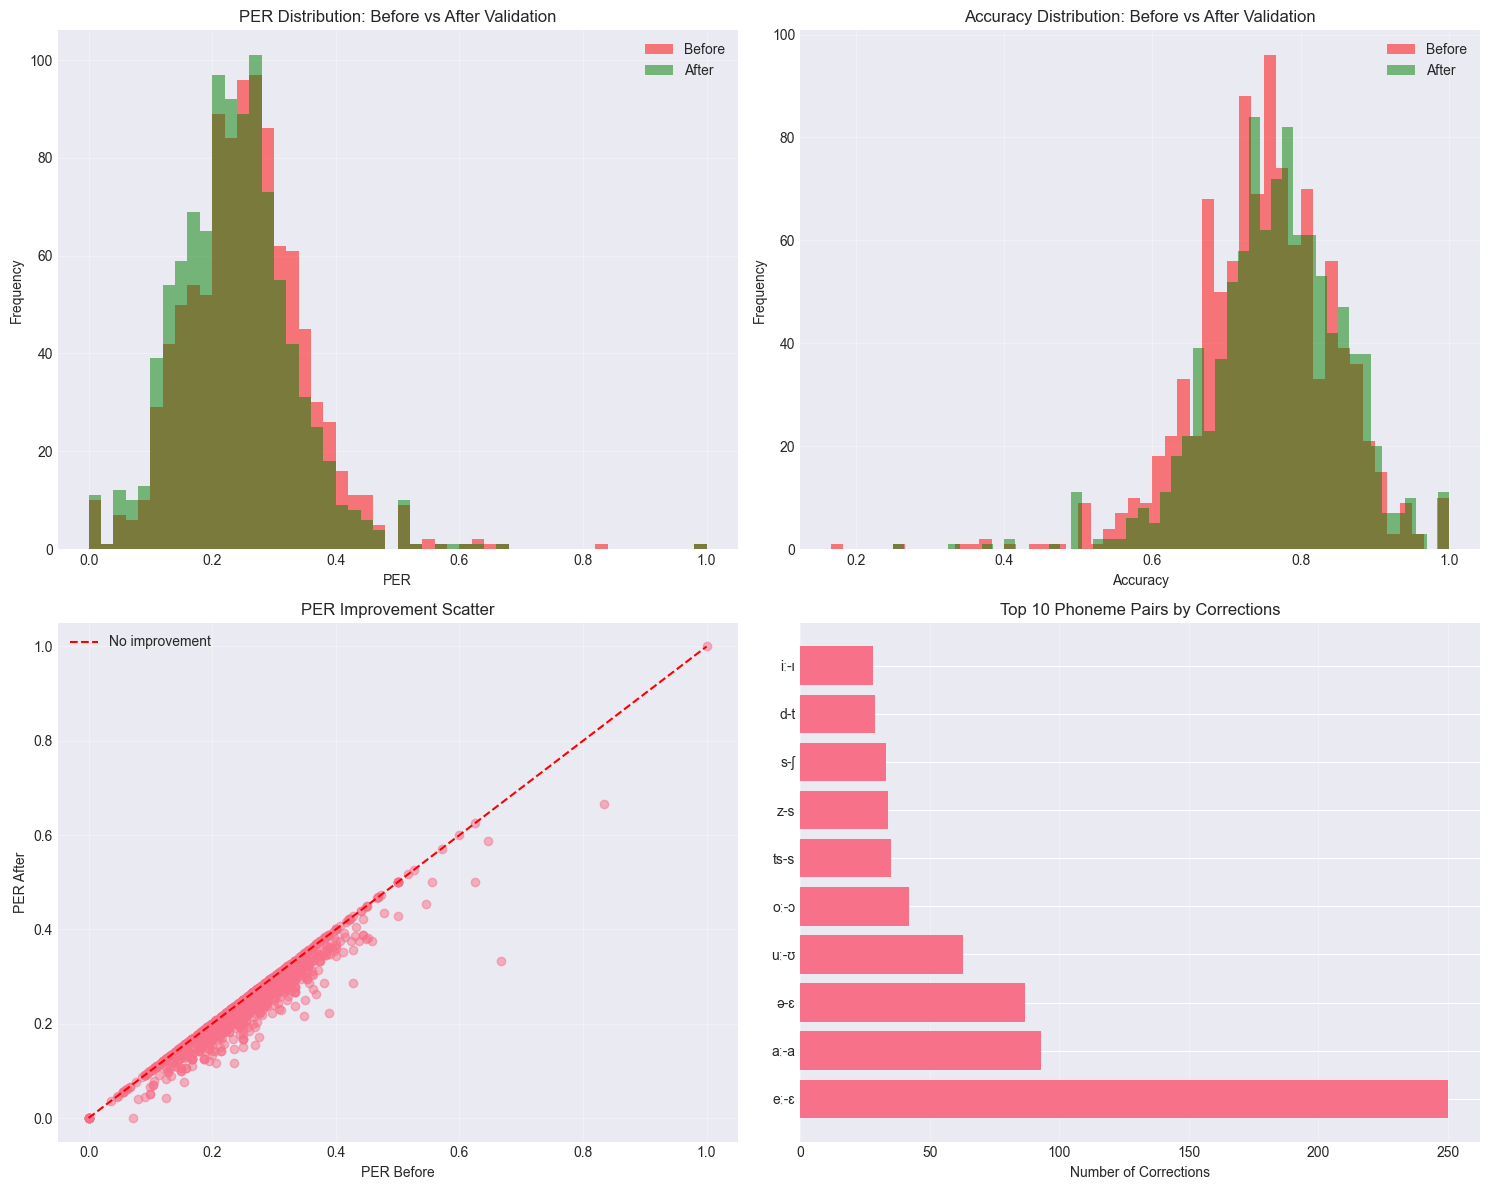

✓ Visualization saved to: data/validation_comparison_stage1.png


In [11]:
# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PER distribution before/after
axes[0, 0].hist(df_sample['per_before'], bins=50, alpha=0.5, label='Before', color='red')
axes[0, 0].hist(df_sample['per_after'], bins=50, alpha=0.5, label='After', color='green')
axes[0, 0].set_xlabel('PER')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('PER Distribution: Before vs After Validation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy distribution
axes[0, 1].hist(df_sample['accuracy_before'], bins=50, alpha=0.5, label='Before', color='red')
axes[0, 1].hist(df_sample['accuracy_after'], bins=50, alpha=0.5, label='After', color='green')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Accuracy Distribution: Before vs After Validation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Improvement scatter
axes[1, 0].scatter(df_sample['per_before'], df_sample['per_after'], alpha=0.5)
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='No improvement')
axes[1, 0].set_xlabel('PER Before')
axes[1, 0].set_ylabel('PER After')
axes[1, 0].set_title('PER Improvement Scatter')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Top corrected pairs bar chart
if len(df_validation) > 0:
    top_corrected_pairs = df_validation[df_validation['was_corrected']].groupby('phoneme_pair').size().sort_values(ascending=False)
    top_10_pairs = top_corrected_pairs.head(10)
    if len(top_10_pairs) > 0:
        axes[1, 1].barh(range(len(top_10_pairs)), top_10_pairs.values)
        axes[1, 1].set_yticks(range(len(top_10_pairs)))
        axes[1, 1].set_yticklabels(top_10_pairs.index)
        axes[1, 1].set_xlabel('Number of Corrections')
        axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 1].text(0.5, 0.5, 'No corrections', ha='center', va='center')
        axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')
else:
    axes[1, 1].text(0.5, 0.5, 'No validation data', ha='center', va='center')
    axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')

plt.tight_layout()
plt.savefig(project_root / 'data' / f'validation_comparison{STAGE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to: data/validation_comparison{STAGE_SUFFIX}.png")

## 10. Export Results

In [12]:
# Save detailed results
output_file = project_root / 'data' / f'phoneme_analysis_validation_comparison{STAGE_SUFFIX}.csv'

# Prepare export dataframe
export_df = df_sample[[
    'text', 'has_loanword', 'durationSeconds',
    'per_before', 'per_after', 'per_improvement',
    'accuracy_before', 'accuracy_after', 'accuracy_improvement',
    'match_count_before', 'match_count_after'
]].copy()

# Add validation summary
export_df['validated_pairs'] = df_sample['validation_stats'].apply(lambda s: s['validated_count'])
export_df['corrected_errors'] = df_sample['validation_stats'].apply(lambda s: s['corrected_count'])

export_df.to_csv(output_file, index=False)
print(f"✓ Results saved to: {output_file}")

# Save summary statistics
total_validated = sum(s['validated_count'] for s in df_sample['validation_stats'])
total_corrected = sum(s['corrected_count'] for s in df_sample['validation_stats'])

summary = {
    'total_records': len(df_sample),
    'per_before_mean': float(df_sample['per_before'].mean()),
    'per_after_mean': float(df_sample['per_after'].mean()),
    'per_improvement_mean': float(df_sample['per_improvement'].mean()),
    'accuracy_before_mean': float(df_sample['accuracy_before'].mean()),
    'accuracy_after_mean': float(df_sample['accuracy_after'].mean()),
    'accuracy_improvement_mean': float(df_sample['accuracy_improvement'].mean()),
    'total_validated_pairs': int(total_validated),
    'total_corrected_errors': int(total_corrected),
    'correction_rate': float(total_corrected/total_validated) if total_validated > 0 else 0.0
}

summary_file = project_root / 'data' / f'validation_summary{STAGE_SUFFIX}.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✓ Summary saved to: {summary_file}")

# Display summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
for key, value in summary.items():
    if isinstance(value, float):
        if 'mean' in key or 'rate' in key:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")
print(f"{'='*60}")

✓ Results saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data/phoneme_analysis_validation_comparison_stage1.csv
✓ Summary saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data/validation_summary_stage1.json

FINAL SUMMARY
total_records: 1000
per_before_mean: 25.58%
per_after_mean: 23.73%
per_improvement_mean: 1.84%
accuracy_before_mean: 74.91%
accuracy_after_mean: 76.73%
accuracy_improvement_mean: 1.81%
total_validated_pairs: 1288
total_corrected_errors: 729
correction_rate: 56.60%


## 11. Error Rate Comparison for Validated Phoneme Pairs Only

This section compares error rates (mismatches) **before** and **after** validation, but **only for the 22 phoneme pairs** that have trained models in the Second Validation Step.

This provides a focused view of how well the validation step performs on the pairs it was specifically trained to handle.

Available phoneme pairs in validator: 22
Pairs: a-ɛ, aɪ̯-aː, aʊ̯-aː, aː-a, b-p, d-t, eː-ɛ, g-k, iː-ɪ, kʰ-g, oː-ɔ, s-ʃ, ts-s, tʰ-d, uː-ʊ, x-k, z-s, ç-x, ç-ʃ, ŋ-n, ə-ɛ, ʁ-ɐ

ERROR RATE COMPARISON: Validated Phoneme Pairs Only

Total pairs analyzed: 16
Total occurrences across all pairs: 1328
Total errors before: 1328
Total errors after: 599

Overall error rate before: 100.00%
Overall error rate after: 45.11%
Overall improvement: 54.89%

Detailed comparison by phoneme pair:
--------------------------------------------------------------------------------
Phoneme Pair  Total  Errors Before  Errors After Error Rate Before Error Rate After Improvement Improvement %
        eː-ɛ    423            423           173           100.00%           40.90%      59.10%         59.1%
         ə-ɛ    191            191           104           100.00%           54.45%      45.55%         45.5%
        oː-ɔ    126            126            84           100.00%           66.67%      33.33%         33.3%
   

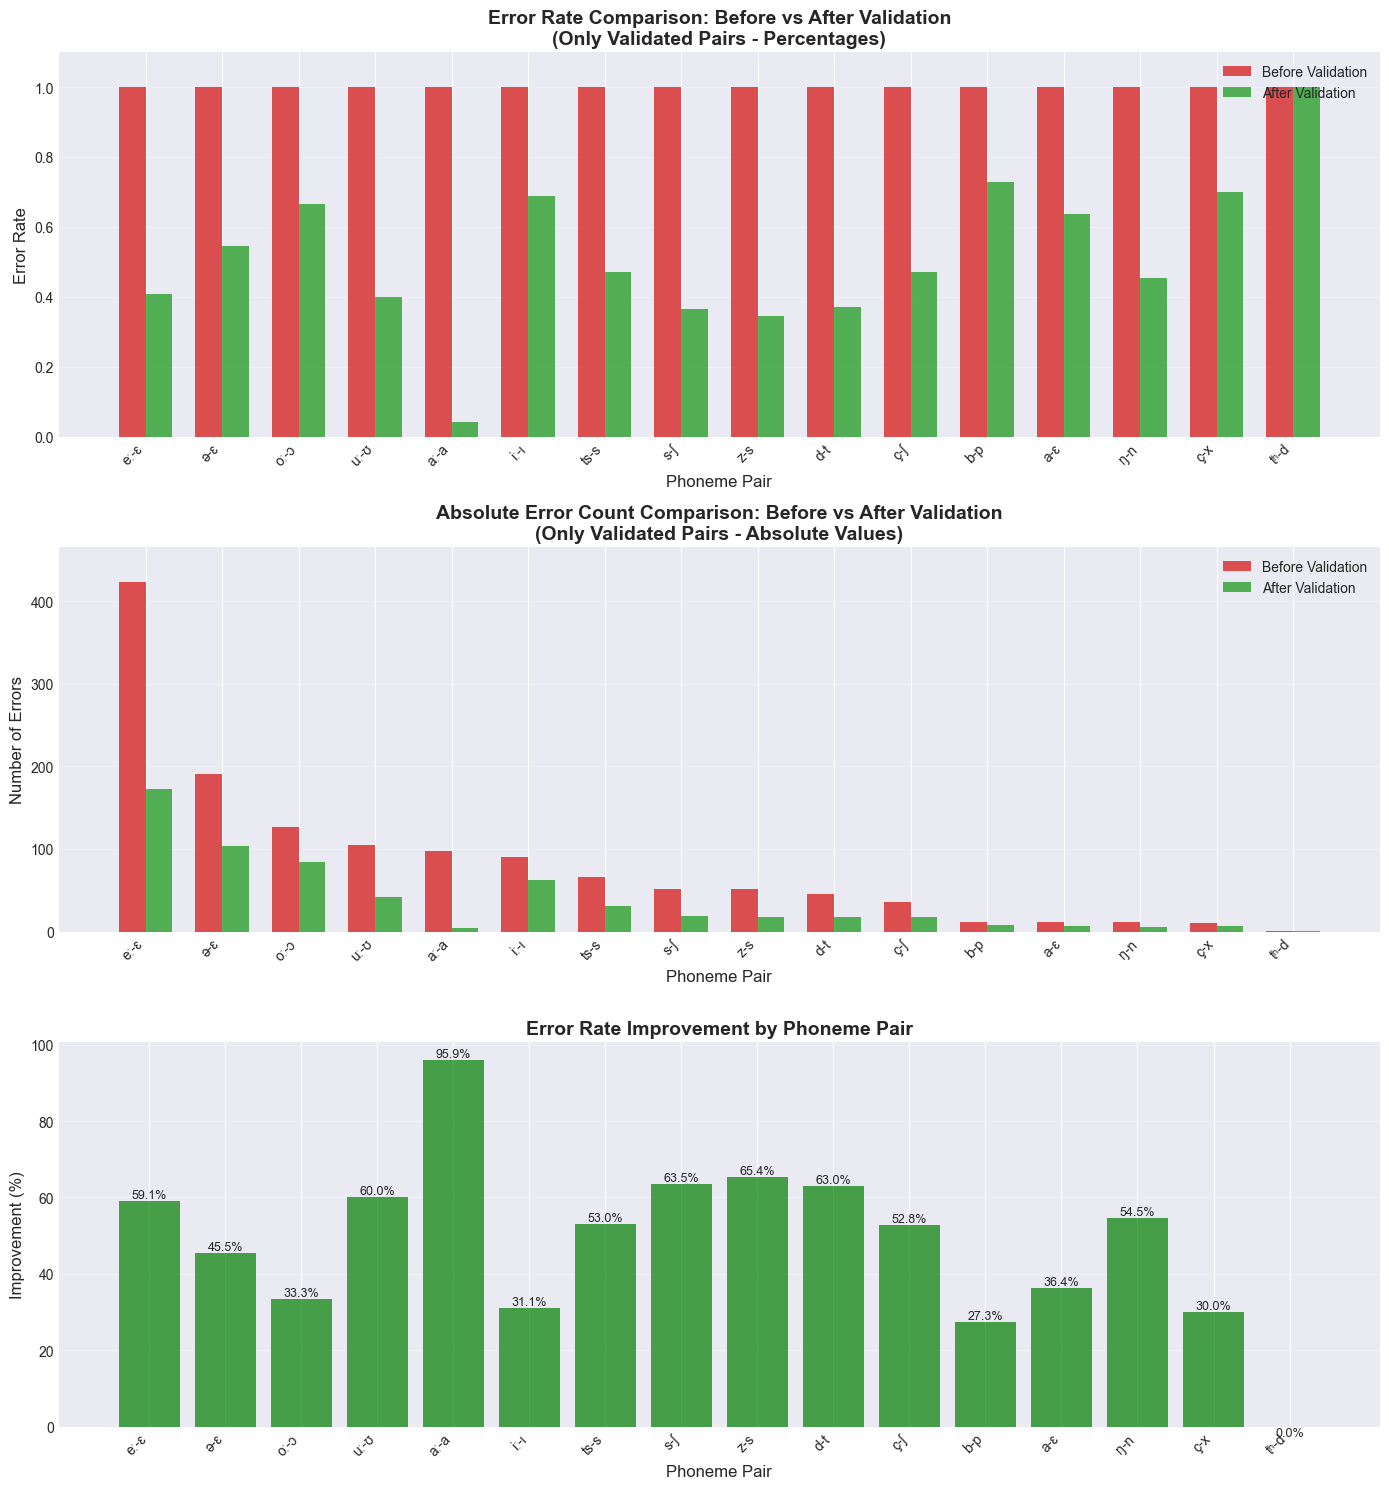


SUMMARY STATISTICS
Pairs with improvement: 15/16
Pairs with no change: 1/16
Pairs with degradation: 0/16

Average improvement: 48.2%
Median improvement: 52.9%
Best improvement: 95.9% (aː-a)


In [13]:
# =============================================================================
# Error Rate Comparison for Validated Phoneme Pairs Only
# =============================================================================
# Compare mismatch rates before and after validation
# Only for the 22 phoneme pairs that have trained models
# =============================================================================

# Get available phoneme pairs from validator
available_pairs = validator.get_available_pairs()
print(f"Available phoneme pairs in validator: {len(available_pairs)}")
print(f"Pairs: {', '.join(sorted(available_pairs))}\n")

# Create a set for fast lookup
available_pairs_set = set(available_pairs)

# Collect mismatch counts for each pair (before and after)
pair_stats = {}

for idx, row in df_sample.iterrows():
    aligned_before = row['aligned_pairs_before']
    aligned_after = row['aligned_pairs_after']
    
    # Count mismatches for each available pair
    for exp, rec in aligned_before:
        # Skip matches, None, or word boundaries
        if exp == rec or exp is None or rec is None:
            continue
        if exp == '||' or rec == '||':
            continue
        
        # Check if this pair is in our available pairs
        # Try both directions: exp-rec and rec-exp
        pair_key = None
        if f"{exp}-{rec}" in available_pairs_set:
            pair_key = f"{exp}-{rec}"
        elif f"{rec}-{exp}" in available_pairs_set:
            pair_key = f"{rec}-{exp}"
        
        if pair_key:
            if pair_key not in pair_stats:
                pair_stats[pair_key] = {'before': 0, 'after': 0, 'total': 0}
            pair_stats[pair_key]['before'] += 1
            pair_stats[pair_key]['total'] += 1
    
    # Count mismatches after validation
    for exp, rec in aligned_after:
        if exp == rec or exp is None or rec is None:
            continue
        if exp == '||' or rec == '||':
            continue
        
        pair_key = None
        if f"{exp}-{rec}" in available_pairs_set:
            pair_key = f"{exp}-{rec}"
        elif f"{rec}-{exp}" in available_pairs_set:
            pair_key = f"{rec}-{exp}"
        
        if pair_key:
            if pair_key not in pair_stats:
                pair_stats[pair_key] = {'before': 0, 'after': 0, 'total': 0}
            pair_stats[pair_key]['after'] += 1

# Create DataFrame for analysis
pair_data = []
for pair, stats in pair_stats.items():
    error_rate_before = stats['before'] / stats['total'] if stats['total'] > 0 else 0.0
    error_rate_after = stats['after'] / stats['total'] if stats['total'] > 0 else 0.0
    improvement = error_rate_before - error_rate_after
    improvement_pct = (improvement / error_rate_before * 100) if error_rate_before > 0 else 0.0
    
    pair_data.append({
        'phoneme_pair': pair,
        'total_occurrences': stats['total'],
        'errors_before': stats['before'],
        'errors_after': stats['after'],
        'error_rate_before': error_rate_before,
        'error_rate_after': error_rate_after,
        'error_rate_improvement': improvement,
        'improvement_percent': improvement_pct
    })

df_pair_comparison = pd.DataFrame(pair_data)
df_pair_comparison = df_pair_comparison.sort_values('total_occurrences', ascending=False)

# Display results
print("="*80)
print("ERROR RATE COMPARISON: Validated Phoneme Pairs Only")
print("="*80)
print(f"\nTotal pairs analyzed: {len(df_pair_comparison)}")
print(f"Total occurrences across all pairs: {df_pair_comparison['total_occurrences'].sum()}")
print(f"Total errors before: {df_pair_comparison['errors_before'].sum()}")
print(f"Total errors after: {df_pair_comparison['errors_after'].sum()}")
print(f"\nOverall error rate before: {df_pair_comparison['errors_before'].sum() / df_pair_comparison['total_occurrences'].sum():.2%}")
print(f"Overall error rate after: {df_pair_comparison['errors_after'].sum() / df_pair_comparison['total_occurrences'].sum():.2%}")
print(f"Overall improvement: {(df_pair_comparison['errors_before'].sum() - df_pair_comparison['errors_after'].sum()) / df_pair_comparison['total_occurrences'].sum():.2%}")
print("="*80)

# Display detailed table
print("\nDetailed comparison by phoneme pair:")
print("-"*80)
display_cols = ['phoneme_pair', 'total_occurrences', 'errors_before', 'errors_after', 
                'error_rate_before', 'error_rate_after', 'error_rate_improvement', 'improvement_percent']
df_display = df_pair_comparison[display_cols].copy()
df_display['error_rate_before'] = df_display['error_rate_before'].apply(lambda x: f"{x:.2%}")
df_display['error_rate_after'] = df_display['error_rate_after'].apply(lambda x: f"{x:.2%}")
df_display['error_rate_improvement'] = df_display['error_rate_improvement'].apply(lambda x: f"{x:.2%}")
df_display['improvement_percent'] = df_display['improvement_percent'].apply(lambda x: f"{x:.1f}%")
df_display.columns = ['Phoneme Pair', 'Total', 'Errors Before', 'Errors After', 
                       'Error Rate Before', 'Error Rate After', 'Improvement', 'Improvement %']
print(df_display.to_string(index=False))
print("-"*80)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Plot 1: Error rates comparison (percentages)
ax1 = axes[0]
x_pos = np.arange(len(df_pair_comparison))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, df_pair_comparison['error_rate_before'], width, 
                label='Before Validation', alpha=0.8, color='#d62728')
bars2 = ax1.bar(x_pos + width/2, df_pair_comparison['error_rate_after'], width,
                label='After Validation', alpha=0.8, color='#2ca02c')

ax1.set_xlabel('Phoneme Pair', fontsize=12)
ax1.set_ylabel('Error Rate', fontsize=12)
ax1.set_title('Error Rate Comparison: Before vs After Validation\n(Only Validated Pairs - Percentages)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(df_pair_comparison['error_rate_before'].max(), 
                     df_pair_comparison['error_rate_after'].max()) * 1.1])

# Plot 2: Absolute error counts comparison
ax2 = axes[1]
bars3 = ax2.bar(x_pos - width/2, df_pair_comparison['errors_before'], width,
                label='Before Validation', alpha=0.8, color='#d62728')
bars4 = ax2.bar(x_pos + width/2, df_pair_comparison['errors_after'], width,
                label='After Validation', alpha=0.8, color='#2ca02c')

ax2.set_xlabel('Phoneme Pair', fontsize=12)
ax2.set_ylabel('Number of Errors', fontsize=12)
ax2.set_title('Absolute Error Count Comparison: Before vs After Validation\n(Only Validated Pairs - Absolute Values)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, max(df_pair_comparison['errors_before'].max(), 
                     df_pair_comparison['errors_after'].max()) * 1.1])

# Plot 3: Improvement percentage
ax3 = axes[2]
colors = ['green' if x > 0 else 'red' for x in df_pair_comparison['improvement_percent']]
bars = ax3.bar(x_pos, df_pair_comparison['improvement_percent'], color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Phoneme Pair', fontsize=12)
ax3.set_ylabel('Improvement (%)', fontsize=12)
ax3.set_title('Error Rate Improvement by Phoneme Pair', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, df_pair_comparison['improvement_percent'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Pairs with improvement: {(df_pair_comparison['improvement_percent'] > 0).sum()}/{len(df_pair_comparison)}")
print(f"Pairs with no change: {(df_pair_comparison['improvement_percent'] == 0).sum()}/{len(df_pair_comparison)}")
print(f"Pairs with degradation: {(df_pair_comparison['improvement_percent'] < 0).sum()}/{len(df_pair_comparison)}")
print(f"\nAverage improvement: {df_pair_comparison['improvement_percent'].mean():.1f}%")
print(f"Median improvement: {df_pair_comparison['improvement_percent'].median():.1f}%")
print(f"Best improvement: {df_pair_comparison['improvement_percent'].max():.1f}% ({df_pair_comparison.loc[df_pair_comparison['improvement_percent'].idxmax(), 'phoneme_pair']})")
if (df_pair_comparison['improvement_percent'] < 0).any():
    print(f"Worst change: {df_pair_comparison['improvement_percent'].min():.1f}% ({df_pair_comparison.loc[df_pair_comparison['improvement_percent'].idxmin(), 'phoneme_pair']})")
print("="*80)

## 10. Timecode Comparison: MFA vs CTC

Compare timecodes between MFA and CTC alignment methods to verify they produce different results.

Comparing MFA vs CTC timecodes...
Loading CTC data from: /Volumes/SSanDisk/SpeechRec-German-diagnostic/notebooks/ctc_segments_comparison.json
Comparing 100 files...


Comparing timecodes:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Saved comparison plot to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/notebooks/timecode_comparison_mfa_ctc.png


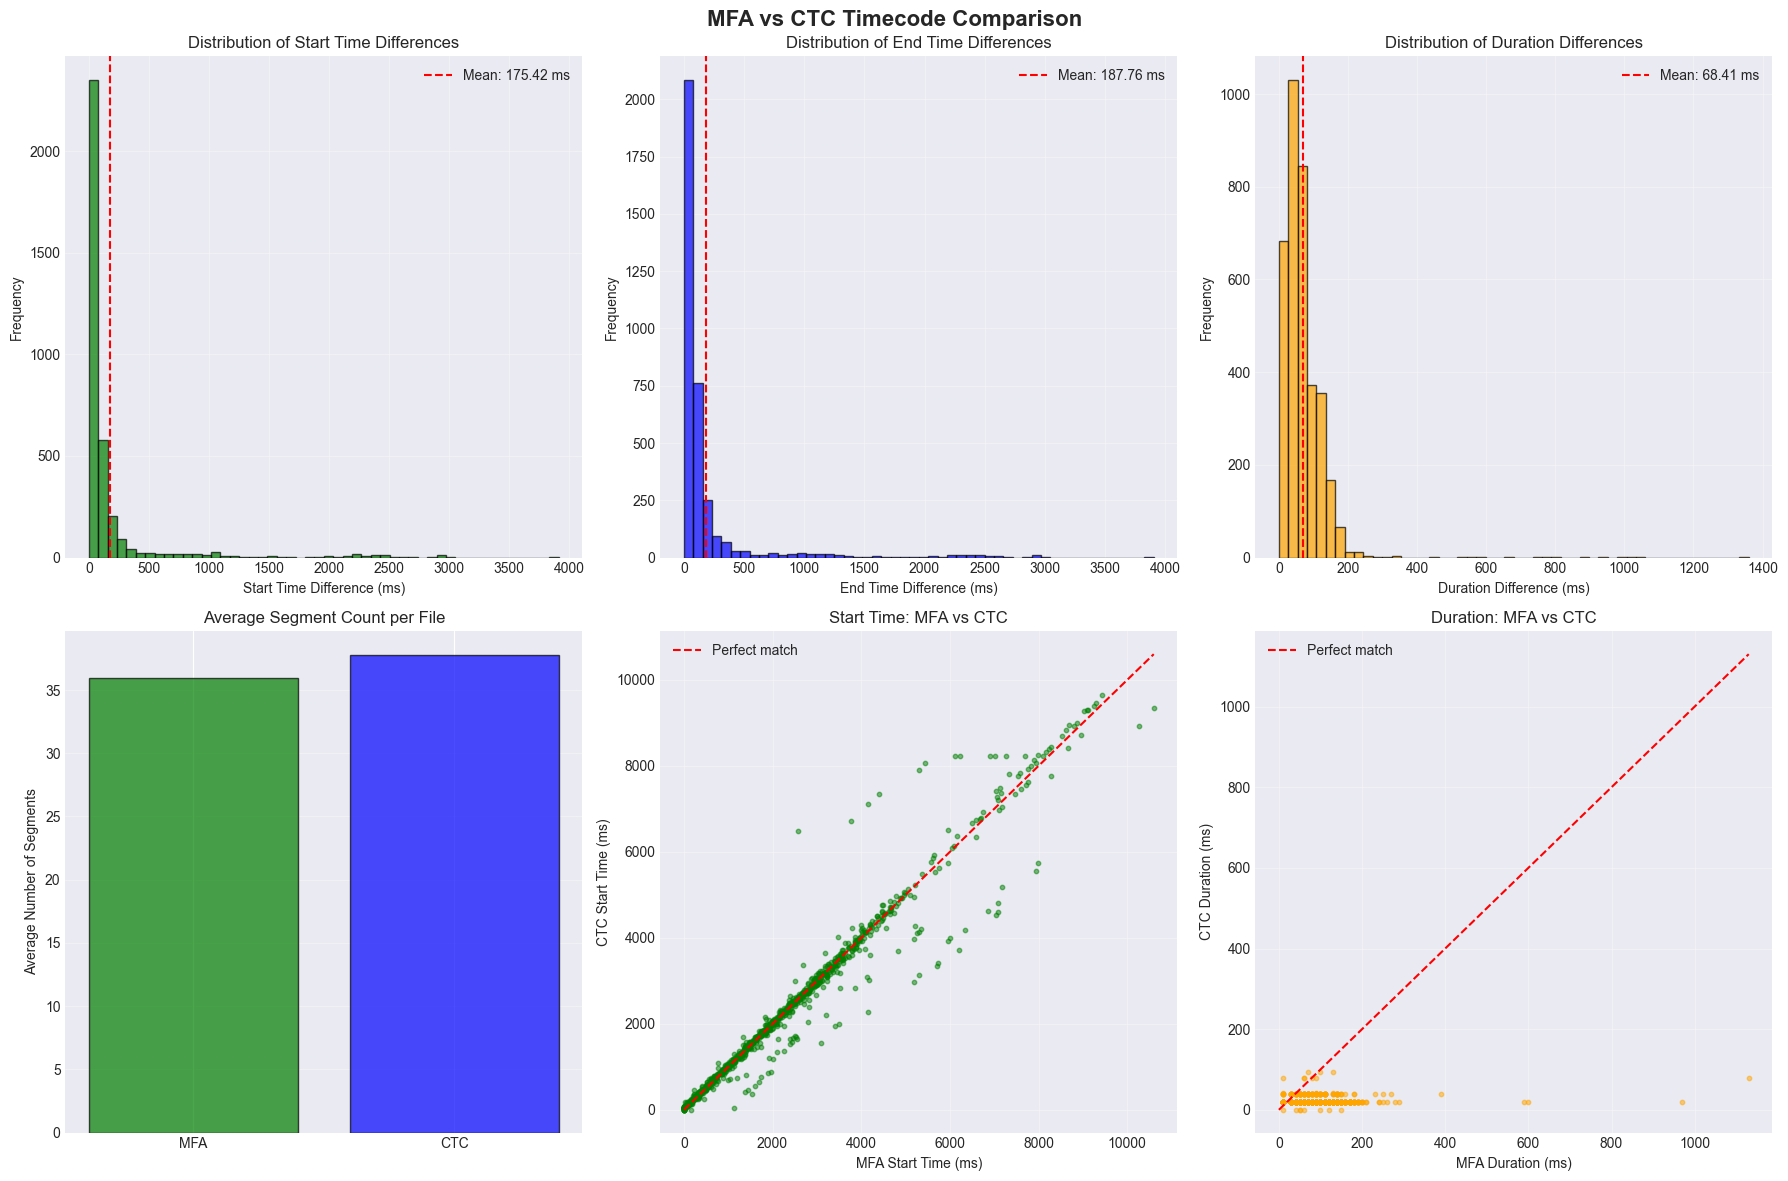


TIMECODE COMPARISON SUMMARY: MFA vs CTC
Total segments compared: 3572

Start Time Differences:
  Mean: 175.42 ms
  Median: 49.97 ms
  Std: 428.65 ms
  Max: 3915.51 ms

End Time Differences:
  Mean: 187.76 ms
  Median: 58.95 ms
  Std: 437.00 ms
  Max: 3905.37 ms

Duration Differences:
  Mean: 68.41 ms
  Median: 59.90 ms
  Std: 68.42 ms
  Max: 1359.96 ms

Segment Counts:
  MFA average: 35.9 segments/file
  CTC average: 37.8 segments/file
  Difference: 1.8 segments/file


In [14]:
# =============================================================================
# Timecode Comparison: MFA vs CTC
# =============================================================================
# This cell compares timecodes between MFA and CTC alignment methods
# Load CTC data from saved file or from CTC notebook

import json

# Try to load CTC comparison data
ctc_comparison_file = project_root / 'notebooks' / 'ctc_segments_comparison.json'
df_mfa_for_comparison = df_sample.copy()

# Use the same comparison functions (copy from CTC notebook or import)
def compare_timecodes_mfa_ctc(df_mfa, df_ctc_data=None, sample_size=100):
    """
    Compare timecodes between MFA and CTC alignment.
    """
    
    if df_ctc_data is None:
        # Try to load from saved file
        if ctc_comparison_file.exists():
            print(f"Loading CTC data from: {ctc_comparison_file}")
            with open(ctc_comparison_file, 'r') as f:
                ctc_data = json.load(f)
            df_ctc_data = ctc_data
        else:
            print("⚠ CTC comparison data not found.")
            print("  Run the comparison cell in CTC notebook first to save CTC data.")
            return None
    
    # Sample files for comparison
    if isinstance(df_ctc_data, dict) and 'indices' in df_ctc_data:
        common_indices = [idx for idx in df_ctc_data['indices'] if idx in df_mfa.index][:sample_size]
        ctc_segments_dict = df_ctc_data.get('segments', {})
    else:
        common_indices = df_mfa.index[:sample_size]
        ctc_segments_dict = {}
    
    if len(common_indices) == 0:
        print("⚠ No common indices found.")
        return None
    
    timecode_differences = []
    segment_counts = {'mfa': [], 'ctc': []}
    
    print(f"Comparing {len(common_indices)} files...")
    
    for idx in tqdm(common_indices, desc="Comparing timecodes"):
        mfa_segments = df_mfa.loc[idx, 'recognized_segments'] if 'recognized_segments' in df_mfa.columns else []
        ctc_segments_list = ctc_segments_dict.get(str(idx), [])
        
        if not mfa_segments or not ctc_segments_list:
            continue
        
        # Count segments
        segment_counts['mfa'].append(len(mfa_segments))
        segment_counts['ctc'].append(len(ctc_segments_list))
        
        # Compare timecodes
        min_len = min(len(mfa_segments), len(ctc_segments_list))
        for i in range(min_len):
            mfa_seg = mfa_segments[i]
            ctc_seg_dict = ctc_segments_list[i] if i < len(ctc_segments_list) else {}
            
            if hasattr(mfa_seg, 'start_time') and 'start_time' in ctc_seg_dict:
                start_diff = abs(mfa_seg.start_time - ctc_seg_dict['start_time'])
                end_diff = abs(mfa_seg.end_time - ctc_seg_dict['end_time'])
                duration_mfa = mfa_seg.end_time - mfa_seg.start_time
                duration_ctc = ctc_seg_dict['end_time'] - ctc_seg_dict['start_time']
                duration_diff = abs(duration_mfa - duration_ctc)
                
                timecode_differences.append({
                    'file_idx': idx,
                    'phoneme_idx': i,
                    'phoneme': ctc_seg_dict.get('label', '?'),
                    'start_diff': start_diff,
                    'end_diff': end_diff,
                    'duration_diff': duration_diff,
                    'mfa_start': mfa_seg.start_time,
                    'ctc_start': ctc_seg_dict['start_time'],
                    'mfa_end': mfa_seg.end_time,
                    'ctc_end': ctc_seg_dict['end_time'],
                    'mfa_duration': duration_mfa,
                    'ctc_duration': duration_ctc
                })
    
    return {
        'timecode_differences': timecode_differences,
        'segment_counts': segment_counts
    }

# Run comparison
print("Comparing MFA vs CTC timecodes...")
comparison_data = compare_timecodes_mfa_ctc(df_mfa_for_comparison, sample_size=100)

if comparison_data:
    # Use the same plotting function (reuse from CTC notebook or define here)
    from matplotlib import pyplot as plt
    import numpy as np
    
    timecode_diffs = comparison_data['timecode_differences']
    segment_counts = comparison_data['segment_counts']
    
    if timecode_diffs:
        df_diffs = pd.DataFrame(timecode_diffs)
        
        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('MFA vs CTC Timecode Comparison', fontsize=16, fontweight='bold')
        
        # 1. Start time differences
        axes[0, 0].hist(df_diffs['start_diff'] * 1000, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 0].set_xlabel('Start Time Difference (ms)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Start Time Differences')
        mean_start = df_diffs['start_diff'].mean() * 1000
        axes[0, 0].axvline(mean_start, color='red', linestyle='--', label=f'Mean: {mean_start:.2f} ms')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. End time differences
        axes[0, 1].hist(df_diffs['end_diff'] * 1000, bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 1].set_xlabel('End Time Difference (ms)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of End Time Differences')
        mean_end = df_diffs['end_diff'].mean() * 1000
        axes[0, 1].axvline(mean_end, color='red', linestyle='--', label=f'Mean: {mean_end:.2f} ms')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Duration differences
        axes[0, 2].hist(df_diffs['duration_diff'] * 1000, bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[0, 2].set_xlabel('Duration Difference (ms)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('Distribution of Duration Differences')
        mean_dur = df_diffs['duration_diff'].mean() * 1000
        axes[0, 2].axvline(mean_dur, color='red', linestyle='--', label=f'Mean: {mean_dur:.2f} ms')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Segment count comparison
        if segment_counts['mfa'] and segment_counts['ctc']:
            axes[1, 0].bar(['MFA', 'CTC'], 
                           [np.mean(segment_counts['mfa']), np.mean(segment_counts['ctc'])],
                           color=['green', 'blue'], alpha=0.7, edgecolor='black')
            axes[1, 0].set_ylabel('Average Number of Segments')
            axes[1, 0].set_title('Average Segment Count per File')
            axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # 5. Scatter: MFA vs CTC start times
        sample_df = df_diffs.sample(min(1000, len(df_diffs)))
        axes[1, 1].scatter(sample_df['mfa_start'] * 1000, sample_df['ctc_start'] * 1000,
                          alpha=0.5, s=10, color='green')
        max_val = max(sample_df['mfa_start'].max(), sample_df['ctc_start'].max()) * 1000
        axes[1, 1].plot([0, max_val], [0, max_val], 'r--', label='Perfect match')
        axes[1, 1].set_xlabel('MFA Start Time (ms)')
        axes[1, 1].set_ylabel('CTC Start Time (ms)')
        axes[1, 1].set_title('Start Time: MFA vs CTC')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Scatter: MFA vs CTC durations
        axes[1, 2].scatter(sample_df['mfa_duration'] * 1000, sample_df['ctc_duration'] * 1000,
                          alpha=0.5, s=10, color='orange')
        max_dur = max(sample_df['mfa_duration'].max(), sample_df['ctc_duration'].max()) * 1000
        axes[1, 2].plot([0, max_dur], [0, max_dur], 'r--', label='Perfect match')
        axes[1, 2].set_xlabel('MFA Duration (ms)')
        axes[1, 2].set_ylabel('CTC Duration (ms)')
        axes[1, 2].set_title('Duration: MFA vs CTC')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        save_path = project_root / 'notebooks' / 'timecode_comparison_mfa_ctc.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved comparison plot to: {save_path}")
        plt.show()
        
        # Print summary
        print(f"\n{'='*80}")
        print("TIMECODE COMPARISON SUMMARY: MFA vs CTC")
        print(f"{'='*80}")
        print(f"Total segments compared: {len(df_diffs)}")
        print(f"\nStart Time Differences:")
        print(f"  Mean: {df_diffs['start_diff'].mean()*1000:.2f} ms")
        print(f"  Median: {df_diffs['start_diff'].median()*1000:.2f} ms")
        print(f"  Std: {df_diffs['start_diff'].std()*1000:.2f} ms")
        print(f"  Max: {df_diffs['start_diff'].max()*1000:.2f} ms")
        print(f"\nEnd Time Differences:")
        print(f"  Mean: {df_diffs['end_diff'].mean()*1000:.2f} ms")
        print(f"  Median: {df_diffs['end_diff'].median()*1000:.2f} ms")
        print(f"  Std: {df_diffs['end_diff'].std()*1000:.2f} ms")
        print(f"  Max: {df_diffs['end_diff'].max()*1000:.2f} ms")
        print(f"\nDuration Differences:")
        print(f"  Mean: {df_diffs['duration_diff'].mean()*1000:.2f} ms")
        print(f"  Median: {df_diffs['duration_diff'].median()*1000:.2f} ms")
        print(f"  Std: {df_diffs['duration_diff'].std()*1000:.2f} ms")
        print(f"  Max: {df_diffs['duration_diff'].max()*1000:.2f} ms")
        if segment_counts['mfa'] and segment_counts['ctc']:
            print(f"\nSegment Counts:")
            print(f"  MFA average: {np.mean(segment_counts['mfa']):.1f} segments/file")
            print(f"  CTC average: {np.mean(segment_counts['ctc']):.1f} segments/file")
            print(f"  Difference: {abs(np.mean(segment_counts['mfa']) - np.mean(segment_counts['ctc'])):.1f} segments/file")
        print(f"{'='*80}")
    else:
        print("No timecode differences found.")
else:
    print("⚠ Could not perform comparison. Make sure CTC notebook comparison cell was run first.")

## 12. Top 10 Sentences with Most Corrections

This section identifies the sentences where the Second Validation Step corrected the most phoneme errors. These are the sentences that benefited the most from the validation process.

In [15]:
# =============================================================================
# Top 10 Sentences with Most Corrections
# =============================================================================
# Find sentences where the Second Validation Step corrected the most errors
# =============================================================================

# Extract correction counts for each sentence
correction_data = []
for idx, row in df_sample.iterrows():
    stats = row['validation_stats']
    corrected_count = stats.get('corrected_count', 0)
    validated_count = stats.get('validated_count', 0)
    
    # Calculate metrics
    per_before = row.get('per_before', 0.0)
    per_after = row.get('per_after', 0.0)
    accuracy_before = row.get('accuracy_before', 0.0)
    accuracy_after = row.get('accuracy_after', 0.0)
    
    correction_data.append({
        'index': idx,
        'text': row['text'],
        'corrected_count': corrected_count,
        'validated_count': validated_count,
        'per_before': per_before,
        'per_after': per_after,
        'per_improvement': per_before - per_after,
        'accuracy_before': accuracy_before,
        'accuracy_after': accuracy_after,
        'accuracy_improvement': accuracy_after - accuracy_before,
        'has_loanword': row.get('has_loanword', False)
    })

df_corrections = pd.DataFrame(correction_data)
df_corrections = df_corrections.sort_values('corrected_count', ascending=False)

# Get top 10
top_10 = df_corrections.head(10)

# Display results
print("="*80)
print("TOP 10 SENTENCES WITH MOST CORRECTIONS")
print("="*80)
print(f"\nTotal sentences analyzed: {len(df_corrections)}")
print(f"Total corrections across all sentences: {df_corrections['corrected_count'].sum()}")
print(f"Average corrections per sentence: {df_corrections['corrected_count'].mean():.2f}")
print(f"Max corrections in a single sentence: {df_corrections['corrected_count'].max()}")
print("="*80)

print("\n" + "="*80)
print("TOP 10 SENTENCES:")
print("="*80)

for rank, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{'='*80}")
    print(f"Rank #{rank}")
    print(f"{'='*80}")
    print(f"Text: {row['text']}")
    print(f"\nCorrections:")
    print(f"  - Corrected errors: {row['corrected_count']}")
    print(f"  - Validated pairs: {row['validated_count']}")
    print(f"  - Correction rate: {row['corrected_count']/row['validated_count']*100:.1f}%" if row['validated_count'] > 0 else "  - Correction rate: N/A")
    print(f"\nMetrics:")
    print(f"  - PER before: {row['per_before']:.2%}")
    print(f"  - PER after: {row['per_after']:.2%}")
    print(f"  - PER improvement: {row['per_improvement']:.2%}")
    print(f"  - Accuracy before: {row['accuracy_before']:.2%}")
    print(f"  - Accuracy after: {row['accuracy_after']:.2%}")
    print(f"  - Accuracy improvement: {row['accuracy_improvement']:.2%}")
    print(f"  - Contains loanword: {'Yes' if row['has_loanword'] else 'No'}")

print(f"\n{'='*80}")
print("SUMMARY")
print("="*80)
print(f"Average corrections in top 10: {top_10['corrected_count'].mean():.1f}")
print(f"Total corrections in top 10: {top_10['corrected_count'].sum()}")
print(f"Percentage of all corrections: {top_10['corrected_count'].sum() / df_corrections['corrected_count'].sum() * 100:.1f}%")
print(f"Average PER improvement in top 10: {top_10['per_improvement'].mean():.2%}")
print(f"Average accuracy improvement in top 10: {top_10['accuracy_improvement'].mean():.2%}")
print("="*80)

# Create a summary table
print("\n" + "="*80)
print("TOP 10 SENTENCES - SUMMARY TABLE")
print("="*80)
summary_cols = ['text', 'corrected_count', 'validated_count', 'per_before', 'per_after', 
                'per_improvement', 'accuracy_improvement']
df_summary = top_10[summary_cols].copy()
df_summary['per_before'] = df_summary['per_before'].apply(lambda x: f"{x:.2%}")
df_summary['per_after'] = df_summary['per_after'].apply(lambda x: f"{x:.2%}")
df_summary['per_improvement'] = df_summary['per_improvement'].apply(lambda x: f"{x:.2%}")
df_summary['accuracy_improvement'] = df_summary['accuracy_improvement'].apply(lambda x: f"{x:.2%}")
df_summary.columns = ['Text', 'Corrections', 'Validated', 'PER Before', 'PER After', 
                       'PER Improvement', 'Accuracy Improvement']
# Truncate long text for display
df_summary['Text'] = df_summary['Text'].apply(lambda x: x[:60] + '...' if len(x) > 60 else x)
print(df_summary.to_string(index=False))
print("="*80)

TOP 10 SENTENCES WITH MOST CORRECTIONS

Total sentences analyzed: 1000
Total corrections across all sentences: 729
Average corrections per sentence: 0.73
Max corrections in a single sentence: 6

TOP 10 SENTENCES:

Rank #1
Text: Im Grundlagenstreit der Mathematik entspräche der nominalistischen Position die formalistische Richtung.

Corrections:
  - Corrected errors: 6
  - Validated pairs: 7
  - Correction rate: 85.7%

Metrics:
  - PER before: 19.51%
  - PER after: 12.20%
  - PER improvement: 7.32%
  - Accuracy before: 80.95%
  - Accuracy after: 88.10%
  - Accuracy improvement: 7.14%
  - Contains loanword: No

Rank #2
Text: Die Anfrage, zumindest im Vorprogramm der "Turn-It-On-Again"-Welttournee aufzutreten, sei vom Genesis-Management konsequent unterbunden worden.

Corrections:
  - Corrected errors: 6
  - Validated pairs: 8
  - Correction rate: 75.0%

Metrics:
  - PER before: 36.13%
  - PER after: 31.09%
  - PER improvement: 5.04%
  - Accuracy before: 64.46%
  - Accuracy after: 69.42%
